In [1]:
import sys
import os
import re

%matplotlib notebook
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pylab as plt
import sys
import glob, os


curr_ld_lib_path = ''
os.environ['LD_LIBRARY_PATH'] = curr_ld_lib_path + ':/project/projectdirs/openmsi/jupyterhub_libs/boost_1_55_0/lib' + ':/project/projectdirs/openmsi/jupyterhub_libs/lib'
import sys
# sys.path.remove('/anaconda/lib/python2.7/site-packages')
sys.path.append('/global/project/projectdirs/openmsi/jupyterhub_libs/anaconda/lib/python2.7/site-packages')

sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )

from metatlas import metatlas_objects as metob
from metatlas import h5_query as h5q
from metatlas import mzml_to_hdf


sys.path.append('/project/projectdirs/openmsi/projects/meta-iq/pactolus/pactolus')

import score_frag_dag

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
# from rdkit.Chem.rdMolDescriptors import ExactMolWt
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG,display

In [ ]:
# These are the tests:
#         if len(Chem.GetMolFrags(mol, sanitizeFrags=False, asMols=False)) != 1:
#             raise TypeError('Molecule must be fully connected by covalent bonds.')

#         if Chem.RemoveHs(mol).GetNumAtoms() != mol.GetNumAtoms():
#             raise TypeError('Molecule must have only implicit H atoms.')

#         if GetFormalCharge(mol) != 0:
#             raise TypeError('Molecule must have overall neutral charge.')

In [2]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
#     mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            rms_smiles = Chem.MolToSmiles(rms[0])
            mol = Chem.MolFromSmiles(rms_smiles)
    if replaced:
        return (mol, True) #Chem.MolToSmiles(mol,True)
    else:
        return (mol, False)
def drawStructure_ShowingFragment(pactolus_tree,fragment_idx,myMol,myMol_w_Hs):

    drawer = rdMolDraw2D.MolDraw2DSVG(600,300)

    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr'])[0]
    mark_atoms_no_H = []
    for a_index in fragment_atoms:
        if myMol_w_Hs.GetAtomWithIdx(a_index).GetSymbol() != 'H':
            mark_atoms_no_H.append(a_index)

    rdDepictor.Compute2DCoords(myMol)

    drawer.DrawMolecule(myMol,highlightAtoms=mark_atoms_no_H)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return svg

def drawStructure_Fragment(pactolus_tree,fragment_idx,myMol,myMol_w_Hs):
    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr'])[0]
    depth_of_hit = np.sum(pactolus_tree[fragment_idx]['bond_bool_arr'])
    mol2 = deepcopy(myMol_w_Hs)
    # Now set the atoms you'd like to remove to dummy atoms with atomic number 0
    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr']==False)[0]
    for f in fragment_atoms:
        mol2.GetAtomWithIdx(f).SetAtomicNum(0)

    # Now remove dummy atoms using a query
    mol3 = Chem.DeleteSubstructs(mol2, Chem.MolFromSmarts('[#0]'))
    mol3 = Chem.RemoveHs(mol3)
    # You get what you are looking for
    return moltosvg(mol3),depth_of_hit


def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

def get_ion_from_fragment(frag_info,spectrum):
    hit_indices = np.where(np.sum(frag_info,axis=1))
    hit = spectrum[hit_indices,:][0]
    return hit,hit_indices

In [4]:
allCompounds = metob.retrieve('Compounds',InchI='InchI%')
print len(allCompounds)
allCompounds[0]
#11539 trees of depth 5 Curt had before I messed with it.

11875


{'InChI': u'InChI=1S/C15H24/c1-11(2)13-8-9-14-7-5-6-12(3)15(14,4)10-13/h7,12-13H,1,5-6,8-10H2,2-4H3/t12-,13-,15-/m1/s1',
 'MonoIsotopic_molecular_weight': 204.18780517578125,
 'creation_time': '2015-10-08T17:37:27',
 'description': u'',
 'formula': u'C15H24',
 'functional_sets': [],
 'head_id': u'0005ec9d4a8e4f1c9bd7cdee585a1ebc',
 'last_modified': '2015-10-08T17:38:13',
 'name': u'(-)-4-epieremophilene',
 'prev_uid': u'origin',
 'reference_xrefs': [],
 'synonyms': u'',
 'unique_id': u'0005ec9d4a8e4f1c9bd7cdee585a1ebc',
 'url': u'',
 'username': u'bpb'}

In [3]:
idx = 2292 #345 #33
myMol = Chem.MolFromInchi(str(allCompounds[idx].InChI))
myCharge = Chem.GetFormalCharge(myMol)
print myCharge
print Chem.MolToSmiles(myMol)
SVG(moltosvg(myMol))


NameError: name 'allCompounds' is not defined

0
CC(C)=CCCC(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC=C(C)C
True


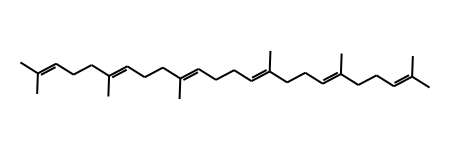

In [113]:
if  myCharge != 0:
    (myMol, neutralised) = NeutraliseCharges(myMol)
print Chem.GetFormalCharge(myMol)
print Chem.MolToSmiles(myMol)
print neutralised
SVG(moltosvg(myMol))

In [78]:
all_my_h5_files = glob.glob('/global/project/projectdirs/openmsi/projects/ben_trees/*_hdf5_5_*.h5')
inchi_keys = []
for f in all_my_h5_files:
    temp = f.replace('/global/project/projectdirs/openmsi/projects/ben_trees/FragTreeLibrary_test_hdf5_5_','').replace('h5','').replace('.','')
    inchi_keys.append(temp)
len(inchi_keys)
#was 13189 before

13189

In [ ]:
# molecules not connected by covalent bonds = MANY!!!
# molecules not neutral = MANY!!!

In [86]:
# get inchi key for neutralized molecules
ik = []
nb = []
inchi = []
original_idx = []
charge = []
for idx,myCompound in enumerate(allCompounds):
    myMol = Chem.MolFromInchi(str(myCompound.InChI))
    try:
        if len(Chem.GetMolFrags(myMol, sanitizeFrags=False, asMols=False)) == 1:
            myCharge = Chem.GetFormalCharge(myMol)
            if  myCharge != 0:
                (myMol, neutralised) = NeutraliseCharges(myMol)
                myCharge = Chem.GetFormalCharge(myMol)
            if myCharge == 0:
                i = Chem.MolToInchi(myMol)
                inchi.append(i)
                ik.append(Chem.InchiToInchiKey(i))
                nb.append(myMol.GetNumBonds())
                charge.append(Chem.GetFormalCharge(myMol))
                original_idx.append(idx)
    except:
        print "Can not parse ", myCompound.name, myCompound.InChI


    

In [87]:
len(charge)

11443

In [88]:
import numpy as np
print np.sort(charge)[::-1]

[0 0 0 ..., 0 0 0]


In [82]:
from rdkit.Chem.rdmolops import GetFormalCharge
for i,mykey in enumerate(ik):
    try:
        inchi_keys.index(mykey)
    except:
        mol = Chem.MolFromInchi(inchi[i])
#         rms_smiles = Chem.MolToSmiles(mol)
#         mol = Chem.MolFromSmiles(rms_smiles)
        if Chem.GetFormalCharge(mol) != 0:
#             raise TypeError('Molecule must have overall neutral charge.')
#         if len(Chem.GetMolFrags(mol, sanitizeFrags=False, asMols=False)) != 1:
#             print original_idx[i],allCompounds[original_idx[i]].name,' must behave neutral charge.'

IndentationError: expected an indented block (<ipython-input-82-9622886c00cf>, line 12)

In [106]:
# go through all metatlas compounds and see which ones have not been made yet
# so far, up to #nbonds=49 have been run.


c=0
no_tree = {}
no_tree['original_id'] = []
no_tree['num_bonds'] = []
no_tree['name'] = []
no_tree['inchi'] = []

for i,mykey in enumerate(ik):
    try:
        inchi_keys.index(mykey)
    except:
        if nb[i]>2:
    #         print "ID =",original_idx[i],"#bonds =",nb[i],"\t",allCompounds[original_idx[i]].name, "is not created yet"
            no_tree['original_id'].append(original_idx[i])
            no_tree['num_bonds'].append(nb[i])
            no_tree['name'].append(allCompounds[original_idx[i]].name)
            no_tree['inchi'].append(inchi[i])
        c=c+1
        
print c


1707


In [111]:
idx = np.argsort(no_tree['num_bonds'])
fid = open('inchis_remaining_20151111.txt','wb')
for i in idx:
    print "ID =",no_tree['original_id'][i],"# Bonds =",no_tree['num_bonds'][i],no_tree['name'][i]
    fid.write('%s\n'%no_tree['inchi'][i])
fid.close()

ID = 969 # Bonds = 25 [1-(2-amino-7-methyl-4-oxo-7,8-dihydro-3H-pteridin-6-yl)]ethyl diphosphate
ID = 2292 # Bonds = 29 |squalene|
ID = 6163 # Bonds = 31 marneral
ID = 10892 # Bonds = 31 5-hydroxy-CTP
ID = 11469 # Bonds = 33 dammara-20,24-dien
ID = 5188 # Bonds = 34 <i>N</i>-(2-hydroxydodecanoyl)-4,8-sphingadienine
ID = 7867 # Bonds = 34 phylloquinol
ID = 8233 # Bonds = 34 lanosterol
ID = 6132 # Bonds = 34 24-ethylidenelophenol
ID = 11099 # Bonds = 35 N-(2-hydroxydodecanoyl)-phytosphingosine
ID = 1501 # Bonds = 35 &beta;-amyrin
ID = 8026 # Bonds = 35 dammarenediol II
ID = 5061 # Bonds = 35 cycloartenol
ID = 7726 # Bonds = 35 14-hydroxylanosterol
ID = 1343 # Bonds = 35 isoarborinol
ID = 6738 # Bonds = 35 &omega;-hydroxyphylloquinone
ID = 1683 # Bonds = 35 <i>N</i>-(2-hydroxytridecanoyl)-4,8-sphingadienine
ID = 8273 # Bonds = 35 24(25)-dihydrocycloartenol
ID = 10998 # Bonds = 35 bauerenol
ID = 4084 # Bonds = 36 protopanaxadiol
ID = 1739 # Bonds = 36 24-methylenecycloartanol
ID = 11819 # 

In [71]:
# >>> b1 = [1,2,3,4,5,9,11,15]
# >>> b2 = [4,5,6,7,8]
# >>> set(b1).intersection(b2)
# set([4, 5])
# made_keys = set(inchi_keys).intersection(ik)
# print len(made_keys)
# diff_set = set(inchi_keys) - set(ik)


# made_keys = set(inchi_keys).intersection(original_ik)
# print len(made_keys)
# made_keys = set(ik).intersection(original_ik)
# print len(made_keys)
# indices = [ ind_dict[x] for x in inter ]

7729


3981

In [8]:
# all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/pactolus_trees/*_hdf5_5_*.h5')
all_compounds = []
for myCompound in metacyc_compounds:
    myMol = Chem.MolFromInchi(myCompound['InChI'])
    try:
        myCharge = Chem.GetFormalCharge(myMol)
        if  myCharge != 0:
            (myMol, neutralised) = NeutraliseCharges(myMol)
            if neutralised == True:
                all_compounds.append(Chem.MolToInchi(myMol))
#             if neutralised == False:
#                 print neutralised, myCompound['Common-Name']
#                 print rdMolDescriptors.CalcMolFormula(neutral_mol)
    except:
        print "Can not parse ", myCompound['Common-Name'], myCompound['InChI']
print len(all_compounds)

Can not parse  chlorite InChI=1S/ClHO2/c2-1-3/h(H,2,3)/p-1
Can not parse  methanetelluronate InChI=1S/CH4O3Te/c1-5(2,3)4/h1H3,(H,2,3,4)/p-1
Can not parse  choline sulfate InChI=1S/C5H13NO4S/c1-6(2,3)4-5-10-11(7,8)9/h4-5H2,1-3H3
Can not parse  chlorate InChI=1S/ClHO3/c2-1(3)4/h(H,2,3,4)
Can not parse  tellurite InChI=1S/H2O3Te/c1-4(2)3/h(H2,1,2,3)/p-2
Can not parse  dichlorocarbene InChI=1S/CCl2/c2-1-3
5732


In [38]:
myMol.GetNumBonds()

51

In [37]:
fid = open('actinorhodin_inchi.txt','wb')
for m in all_compounds:
    if m == neutral_inchi:
        print m.GetNumBonds()
        fid.write('%s\n'%m)
fid.close()

AttributeError: 'str' object has no attribute 'GetNumBonds'

In [46]:
fid = open('neutralized_molecule_inchis_remaining_small.txt','wb')
for m in all_compounds:
    done_already = 0
    ik = Chem.InchiToInchiKey(m)
    myMol = Chem.MolFromInchi(m)
    nb = myMol.GetNumBonds()
    for k in inchi_keys:
        if ik == k and nb < 20:
            done_already = 1
    if done_already == 0:
        fid.write('%s\n'%m)
    else:
        print "done already"
fid.close()


done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already
done already

In [11]:
inchi = 'InChI=1S/C32H26O14/c1-9-21-15(3-11(45-9)5-19(35)36)29(41)23-17(33)7-13(27(39)25(23)31(21)43)14-8-18(34)24-26(28(14)40)32(44)22-10(2)46-12(6-20(37)38)4-16(22)30(24)42/h7-12,33-34,39-40H,3-6H2,1-2H3,(H,35,36)(H,37,38)/p-2/t9-,10-,11+,12+/m1/s1'
myMol = Chem.MolFromInchi(inchi)
inchi_key = Chem.InchiToInchiKey(inchi)
print inchi_key

myCharge = Chem.GetFormalCharge(myMol)
if  myCharge != 0:
    (myMol, neutralised) = NeutraliseCharges(myMol)
neutral_inchi = Chem.MolToInchi(myMol)
print neutral_inchi
neutral_inchi_key = Chem.InchiToInchiKey(neutral_inchi)
print neutral_inchi_key
# inchi_keys.index(neutral_inchi_key)
ik.index(neutral_inchi_key)

VTIKDEXOEJDMJP-WYUUTHIRSA-L
InChI=1S/C32H26O14/c1-9-21-15(3-11(45-9)5-19(35)36)29(41)23-17(33)7-13(27(39)25(23)31(21)43)14-8-18(34)24-26(28(14)40)32(44)22-10(2)46-12(6-20(37)38)4-16(22)30(24)42/h7-12,33-34,39-40H,3-6H2,1-2H3,(H,35,36)(H,37,38)
VTIKDEXOEJDMJP-UHFFFAOYSA-N


6717

In [3]:
import tables

import numpy as np

In [38]:
my_run = metob.retrieve('lcmsrun', name='%20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53%')
print my_run

[{'creation_time': '2015-09-20T03:35:03',
 'description': u'20150914_actinorhodin_finalset_50mm 20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53.mzML',
 'hdf5_file': u'/project/projectdirs/metatlas/raw_data/kblouie/20150914_actinorhodin_finalset_50mm/20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53.h5',
 'head_id': u'ac236419df994a32902c3cd37072d127',
 'last_modified': '2015-10-08T18:32:38',
 'method': None,
 'mzml_file': u'/project/projectdirs/metatlas/raw_data/kblouie/20150914_actinorhodin_finalset_50mm/20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53.mzML',
 'name': u'20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53.mzML',
 'prev_uid': u'origin',
 'sample': None,
 'unique_id': u'ac236419df994a32902c3cd37072d127',
 'username': u'kblouie'}]


In [50]:
with tables.open_file(my_run[0].hdf5_file) as fid:
    data = h5q.get_data(fid,2,0,min_rt = 5.1,max_rt = 7.9,min_precursor_MZ=633.12,max_precursor_MZ = 633.2)
print data['rt']

[ 7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113]


In [51]:
def get_unique_scan_data(data):
    """
    Input:
    data - numpy nd array containing MSMS data
    
    Output:
    rt - retention time of scan
    pmz - precursor m/z of scan
    Both are sorted by descending precursor ion intensity
    
    for data returned from h5query.get_data(),
    return the retention time and precursor m/z
    sorted by descending precursor ion intensity
    """
    urt,idx = np.unique(data['rt'],return_index=True)
    idx
    sx = np.argsort(data['precursor_intensity'][idx])[::-1]
    prt = data['rt'][idx[sx]]
    pmz = data['precursor_MZ'][idx[sx]]
    return prt,pmz


def get_non_redundant_precursor_list(prt,pmz,rt_cutoff,mz_cutoff):
    """
    Input:
    rt - retention time of scan
    pmz - precursor m/z of scan
    Both are sorted by descending precursor ion intensity
    rt_cutoff - 
    mz_cutoff - 
    
    Output:
    list_of_prt - list of 
    list_of_pmz - list of 
    """
    
    list_of_pmz = [] #contains list of precursor m/z [pmz1,pmz2,...,pmz_n]
    list_of_prt = [] #contains list of precursor rt [prt1,prt2,...,prt_n]
    
    for i in range(len(prt)):
        if len(list_of_pmz) == 0:
            # none are in the list yet; so there is nothing to check
            list_of_pmz.append(pmz[i])
            list_of_prt.append(prt[i])
        else:
            # check if new rt qualifies for inclusion
            if min(abs(list_of_prt - prt[i])) > rt_cutoff or min(abs(list_of_pmz - pmz[i])) > mz_cutoff:
                list_of_pmz.append(pmz[i])
                list_of_prt.append(prt[i])
    return list_of_prt,list_of_pmz

In [52]:
prt,pmz = get_unique_scan_data(data)

rt_cutoff = 0.23
mz_cutoff = 0.05
list_of_prt,list_of_pmz = get_non_redundant_precursor_list(prt,pmz,rt_cutoff,mz_cutoff)


In [53]:
#setup data format for searching
pactolus_input = {}
pactolus_input['spectra'] = []
pactolus_input['precursor_mz'] = []
for i,(prt,pmz) in enumerate(zip(list_of_prt,list_of_pmz)):
    idx = np.argwhere((data['precursor_MZ'] == pmz) & (data['rt'] == prt )).flatten()
    arr = np.array([data['mz'][idx], data['i'][idx]]).T
    pactolus_input['spectra'].append(arr)
    pactolus_input['precursor_mz'].append(pmz)
    
pactolus_input

{'precursor_mz': [633.12708],
 'spectra': [array([[  6.02219849e+01,   5.13611426e+03],
         [  6.45197067e+01,   5.31844141e+03],
         [  6.98501816e+01,   5.67258447e+03],
         [  7.65564728e+01,   5.86723633e+03],
         [  1.02837791e+02,   6.63435449e+03],
         [  1.95310944e+02,   6.94508936e+03],
         [  1.95346817e+02,   5.35564795e+03],
         [  2.30951797e+02,   6.08355859e+03],
         [  2.58053192e+02,   1.16679834e+04],
         [  2.59062347e+02,   4.59729961e+04],
         [  2.73077271e+02,   7.24596094e+04],
         [  2.85077332e+02,   2.16664453e+04],
         [  3.07239838e+02,   5.24816797e+03],
         [  4.58103638e+02,   4.89963672e+04],
         [  4.60081451e+02,   3.66318633e+04],
         [  4.66106598e+02,   9.99861328e+03],
         [  4.67118042e+02,   7.16287158e+03],
         [  4.81088440e+02,   9.08090332e+03],
         [  4.83109131e+02,   1.46352406e+05],
         [  4.84119049e+02,   8.25898203e+04],
         [  4.85128

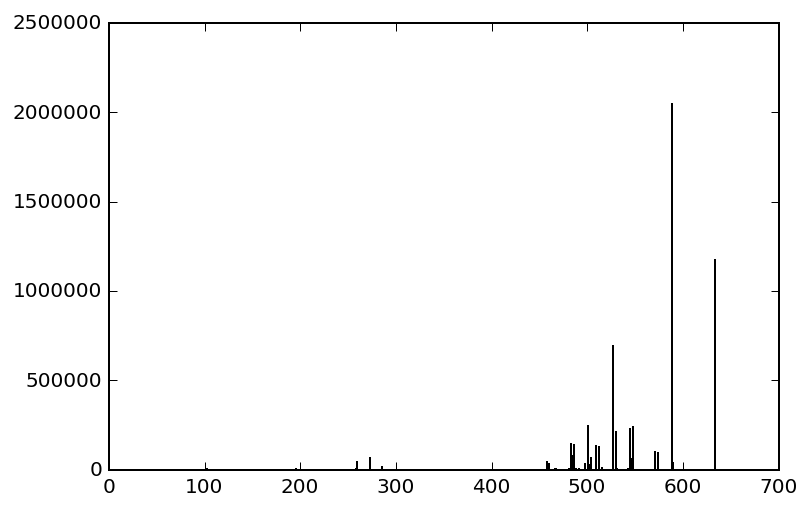

In [46]:
%matplotlib inline
plt.vlines(pactolus_input['spectra'][0][:,0],
           np.zeros(pactolus_input['spectra'][0][:,1].shape),
           pactolus_input['spectra'][0][:,1],
           color='k',linestyles='solid')
plt.show()

In [10]:
# # print data['precursor_MZ']
# # print data['rt']
# # data['mz']
# # data['i']
# # data['precursor_MZ']
# # idx = np.argsort(data['precursor_intensity'])[::-1]
# # data['precursor_intensity'][idx]
# # data['collision_energy']
print list_of_pmz
print list_of_prt
# print len(pmz)

[633.12671]
[7.6977539]


In [71]:
# print len(list_of_pmz_rt)
# print list_of_pmz_rt

In [72]:
# arr = np.array([data['mz'], data['i']]).T
# 
# other_arr = np.array([other_data['mz'], other_data['i']]).T

In [60]:
# all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/pactolus_trees/*VTIKDEXOEJDMJP-WYUUTHIRSA-L*.h5')
for f in all_my_h5_files:
    if "VTIKDEXOEJDMJP" in f:
        print f



In [66]:
tree_table = np.load(maxdepth_5_table)
for t in tree_table:
    if abs(t[1] - 634.132255544) < 1:
        print t

('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_CCDRPBGPIXPGRW-UHFFFAOYSA-N.h5', 634.4080834360016)
('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_WJMMBVSOQPALFO-BHYGPSQDSA-N.h5', 634.4080834360016)
('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_NARQRJFIZNOSJV-UHFFFAOYSA-N.h5', 634.4080834360016)
('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_GJIGVPBRJFOUGD-SSQLMYNASA-N.h5', 634.4749812240018)
('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_HRUXIQZFNLQZQA-UHFFFAOYSA-N.h5', 635.0877176640005)


In [55]:
pos_mode_neutralizations = [-1.00727646677, -(1.00727646677+1.00782504), +5.4857990946e-4,]
neg_mode_neutralizations = [-el for el in pos_mode_neutralizations]

# make lookup table
path_to_trees = '/project/projectdirs/openmsi/projects/pactolus_trees/'
all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/pactolus_trees/*_hdf5_5_*.h5')
my_tree_filename = 'metacyc_max_depth_5'

if not os.path.isfile(os.path.join(path_to_trees, my_tree_filename + '.npy')):
    score_frag_dag.make_file_lookup_table_by_MS1_mass(all_my_h5_files, 
                                                      path=path_to_trees, 
                                                      save_result='metacyc_max_depth_5')

maxdepth_5_table = os.path.join(path_to_trees, my_tree_filename + '.npy')

params = {'file_lookup_table': maxdepth_5_table,
          'ms1_mass_tol': 0.05,
          'ms2_mass_tol': 0.05,
          'neutralizations': neg_mode_neutralizations,
          'max_depth': 5,
              }

print neg_mode_neutralizations

[1.00727646677, 2.0151015067699998, -0.00054857990946]


In [49]:
pactolus_input

{'precursor_mz': [633.12708],
 'spectra': [array([[  6.02219849e+01,   5.13611426e+03],
         [  6.45197067e+01,   5.31844141e+03],
         [  6.98501816e+01,   5.67258447e+03],
         [  7.65564728e+01,   5.86723633e+03],
         [  1.02837791e+02,   6.63435449e+03],
         [  1.95310944e+02,   6.94508936e+03],
         [  1.95346817e+02,   5.35564795e+03],
         [  2.30951797e+02,   6.08355859e+03],
         [  2.58053192e+02,   1.16679834e+04],
         [  2.59062347e+02,   4.59729961e+04],
         [  2.73077271e+02,   7.24596094e+04],
         [  2.85077332e+02,   2.16664453e+04],
         [  3.07239838e+02,   5.24816797e+03],
         [  4.58103638e+02,   4.89963672e+04],
         [  4.60081451e+02,   3.66318633e+04],
         [  4.66106598e+02,   9.99861328e+03],
         [  4.67118042e+02,   7.16287158e+03],
         [  4.81088440e+02,   9.08090332e+03],
         [  4.83109131e+02,   1.46352406e+05],
         [  4.84119049e+02,   8.25898203e+04],
         [  4.85128

In [48]:
foo = score_frag_dag.score_scan_list_against_trees(pactolus_input['spectra'], pactolus_input['precursor_mz'], params)
np.argmax(foo)

0

In [33]:
my_db = '/project/projectdirs/openmsi/projects/meta-iq/pactolus/data/' + 'MetaCyc.mdb'
pactolus_results = score_frag_dag.make_pactolus_hit_table(foo, maxdepth_5_table, original_db=my_db)

In [37]:
for r in pactolus_results:
    if len(r)>0:
        print r[0]

(0.7875834703445435, 'MetaCyC_10461', 'ethyl red', 297.1477355957031, 0, 0)
(0.9809126853942871, 'MetaCyC_7413', 'emodin', 270.0528259277344, 0, 0)
(0.0572817325592041, 'MetaCyC_1181', '(1<i>S</i>,6<i>R</i>)-2-succinyl-6-hydroxy-2,4-cyclohexadiene-1-carboxylate', 240.06338500976562, 0, 0)
(0.23310670256614685, 'MetaCyC_1416', 'tetrachloroethene', 163.8754119873047, 0, 0)
(0.5957505702972412, 'MetaCyC_8529', 'levoglucosan', 162.05282592773438, 0, 0)
(0.0007101739174686372, 'MetaCyC_6396', '2-12:0-lysoPG', 428.217529296875, 0, 0)
(0.33812853693962097, 'MetaCyC_752', 'pentachloroethane', 199.85208129882812, 0, 0)
(0.7275602221488953, 'MetaCyC_9299', 'cortolone', 366.2406311035156, 0, 0)
(1.4161595106124878, 'MetaCyC_7168', '1D-<i>chiro</i>-inositol', 180.06338500976562, 0, 0)
(0.12381210178136826, 'MetaCyC_6694', "3-(2'-methylthio)ethylmalic-acid", 208.04054260253906, 0, 0)
(0.21038520336151123, 'MetaCyC_7088', '3-dehydroteasterone', 446.339599609375, 0, 0)
(0.8556255102157593, 'MetaCyC_7

In [50]:
233.15416+1.00727646677

234.16143646677

In [51]:
234.161979944-234.16143646677

0.0005434772299963697

In [68]:
foo = np.load(maxdepth_5_table)

In [69]:
foo

array([ ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_OOXWYYGXTJLWHA-UHFFFAOYSA-N.h5', 40.031300128),
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_XZMCDFZZKTWFGF-UHFFFAOYSA-N.h5', 42.021798063999995),
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_QQONPFPTGQHPMA-UHFFFAOYSA-N.h5', 42.046950192),
       ...,
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_NTXGVHCCXVHYCL-UHFFFAOYSA-N.h5', 926.6318285440028),
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_HMTFXPJOBPIOIN-UHFFFAOYSA-N.h5', 952.7187878080008),
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_RGHRJBIKIYUHEV-UHFFFAOYSA-N.h5', 952.7187878080008)], 
      dtype=[('filename', 'S400'), ('ms1_mass', '<f8')])